In [1]:
import os
import albumentations as album
import torch
import pytorch_lightning as pl
from albumentations.pytorch.transforms import ToTensorV2
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

# from tablenet import MarmotDataModule
from tablenet import TableNetModule

In [2]:
from pathlib import Path
from typing import List

import numpy as np
import pytorch_lightning as pl
from albumentations import Compose
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class O7Dataset(Dataset):
    """O7 Dataset."""

    def __init__(self, data: List[Path], transforms: Compose = None) -> None:
        """O7 Dataset initialization.

        Args:
            data (List[Path]): A list of Path.
            transforms (Optional[Compose]): Compose object from albumentations.
        """
        self.data = data
        self.transforms = transforms

    def __len__(self):
        """Dataset Length."""
        return len(self.data)

    def __getitem__(self, item):
        """Get sample data.

        Args:
            item (int): sample id.

        Returns (Tuple[tensor, tensor, tensor]): Image, Table Mask, Column Mask
        """
        sample_id = self.data[item].stem

        ann_path  = self.data[item]
        image_path = os.path.join("/home/ubuntu/storage/Doc2Answer/download_from_drive/data/ProcessedO7/", str(ann_path).split("/")[-1].split(".json")[0])
#         table_path = self.data[item].parent.parent.joinpath("table_mask", sample_id + ".bmp")
#         column_path = self.data[item].parent.parent.joinpath("column_mask", sample_id + ".bmp")
        table_path  = os.path.join("/home/ubuntu/storage/Doc2Answer/handigit/OCR_tablenet/masks/table/",   str(image_path).split('/')[-1])
        column_path = os.path.join("/home/ubuntu/storage/Doc2Answer/handigit/OCR_tablenet/masks/columns/", str(image_path).split('/')[-1])

        image = np.array(Image.open(image_path))
        table_mask = np.expand_dims(np.array(Image.open(table_path)), axis=2)
        column_mask = np.expand_dims(np.array(Image.open(column_path)), axis=2)
        mask = np.concatenate([table_mask, column_mask], axis=2) / 255
        sample = {"image": image, "mask": mask}
        if self.transforms:
            sample = self.transforms(image=image, mask=mask)

        image = sample["image"]
        mask_table = sample["mask"][:, :, 0].unsqueeze(0)
        mask_column = sample["mask"][:, :, 1].unsqueeze(0)
        return image, mask_table, mask_column


class O7DataModule(pl.LightningDataModule):
    """Pytorch Lightning Data Module for O7."""

    def __init__(self, data_dir: str = "./data", transforms_preprocessing: Compose = None,
                 transforms_augmentation: Compose = None, batch_size: int = 8, num_workers: int = 4):
        """O7  Data Module initialization.

        Args:
            data_dir (str): Dataset directory.
            transforms_preprocessing (Optional[Compose]): Compose object from albumentations applied
             on validation an test dataset.
            transforms_augmentation (Optional[Compose]): Compose object from albumentations applied
             on training dataset.
            batch_size (int): Define batch size.
            num_workers (int): Define number of workers to process data.
        """
        super().__init__()
        self.data = list(Path(data_dir).rglob("*.jpg.json"))
        self.transforms_preprocessing = transforms_preprocessing
        self.transforms_augmentation = transforms_augmentation
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.setup()

    def setup(self, stage: str = None) -> None:
        """Start training, validation and test datasets.

        Args:
            stage (Optional[str]): Used to separate setup logic for trainer.fit and trainer.test.
        """
        n_samples = len(self.data)
        self.data.sort()
        train_slice = slice(0, int(n_samples * 0.75))
#         val_slice = slice(int(n_samples * 0.8), int(n_samples * 0.9))
        val_slice = slice(int(n_samples * 0.75), n_samples)
#         test_slice = slice(int(n_samples * 0.9), n_samples)

        self.complaint_train = O7Dataset(self.data[train_slice], transforms=self.transforms_augmentation)
        self.complaint_val = O7Dataset(self.data[val_slice], transforms=self.transforms_preprocessing)
        self.complaint_test = O7Dataset(self.data[val_slice], transforms=self.transforms_preprocessing)

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        """Create Dataloader.

        Returns: DataLoader
        """
        return DataLoader(self.complaint_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self, *args, **kwargs) -> DataLoader:
        """Create Dataloader.

        Returns: DataLoader
        """
        return DataLoader(self.complaint_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self, *args, **kwargs) -> DataLoader:
        """Create Dataloader.

        Returns: DataLoader
        """
        return DataLoader(self.complaint_test, batch_size=self.batch_size, num_workers=self.num_workers)


In [3]:
image_size = (896, 896)
transforms_augmentation = album.Compose([
    album.Resize(1024, 1024, always_apply=True),
    album.RandomResizedCrop(*image_size, scale=(0.7, 1.0), ratio=(0.7, 1)),
    album.HorizontalFlip(),
    album.VerticalFlip(),
    album.Normalize(),
    ToTensorV2()
])

transforms_preprocessing = album.Compose([
    album.Resize(*image_size, always_apply=True),
    album.Normalize(),
    ToTensorV2()
])

complaint_dataset = O7DataModule(
    data_dir="/home/ubuntu/storage/Doc2Answer/handigit/annotations/Batch1/ds0/ann/",
    transforms_preprocessing=transforms_preprocessing,
    transforms_augmentation=transforms_augmentation,
    batch_size=2
)

In [4]:
model = TableNetModule(batch_norm=False)

EXPERIMENT_NAME = f"{model.__class__.__name__}"
logger = TensorBoardLogger('tb_logs', name=EXPERIMENT_NAME)

checkpoint_callback = ModelCheckpoint(monitor='validation_loss', save_top_k=5, save_last=True, mode="min")
early_stop_callback = EarlyStopping(monitor='validation_loss', mode="min", patience=10)
lr_monitor = LearningRateMonitor(logging_interval='step')

In [5]:
trainer = pl.Trainer(
    callbacks=[lr_monitor, checkpoint_callback, early_stop_callback],
    logger=logger,
    max_epochs=50,
    gpus=1 if torch.cuda.is_available() else None
)
trainer.fit(model, datamodule=complaint_dataset)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | TableNet | 21.3 M
1 | dice_loss | DiceLoss | 0     
---------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params


Saving latest checkpoint...


1

In [6]:
trainer.test()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_iou_column': 0.32319968938827515,
 'test_iou_table': 0.33249881863594055,
 'test_loss': 0.9174486398696899,
 'test_loss_column': 0.4693089723587036,
 'test_loss_table': 0.4481396973133087}
--------------------------------------------------------------------------------


[{'test_loss_table': 0.4481396973133087,
  'test_loss_column': 0.4693089723587036,
  'test_loss': 0.9174486398696899,
  'test_iou_table': 0.33249881863594055,
  'test_iou_column': 0.32319968938827515}]

In [8]:
train_ds = complaint_dataset.complaint_train
valid_ds = complaint_dataset.complaint_test

../../download_from_drive/data/ProcessedO7/100849_O7_0240.jpg


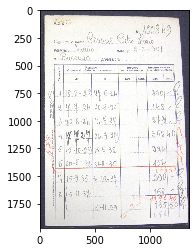


../../download_from_drive/data/ProcessedO7/100849_O7_0242.jpg


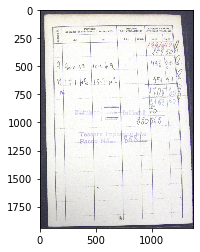


../../download_from_drive/data/ProcessedO7/100849_O7_0244.jpg


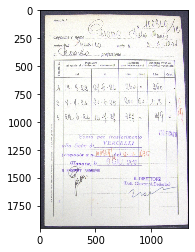


../../download_from_drive/data/ProcessedO7/10231_O7_0067.jpg


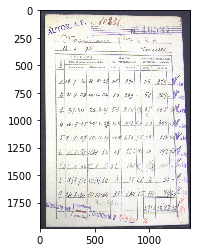


../../download_from_drive/data/ProcessedO7/103445_O7_0206.jpg


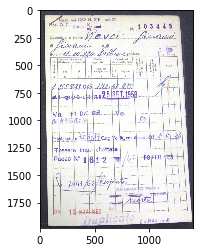


../../download_from_drive/data/ProcessedO7/103445_O7_0208.jpg


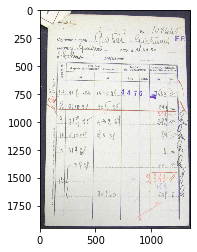


../../download_from_drive/data/ProcessedO7/103445_O7_0210.jpg


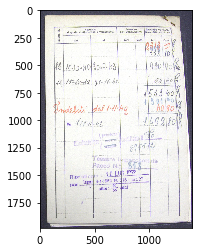


../../download_from_drive/data/ProcessedO7/105281_O7_0160.jpg


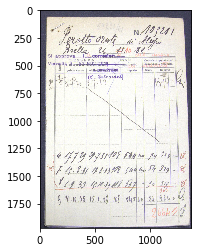


../../download_from_drive/data/ProcessedO7/105281_O7_0162.jpg


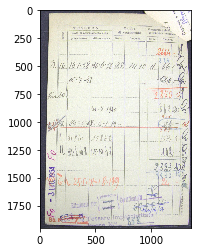


../../download_from_drive/data/ProcessedO7/105281_O7_0164.jpg


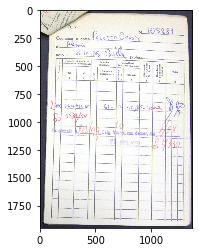


../../download_from_drive/data/ProcessedO7/105281_O7_0166.jpg


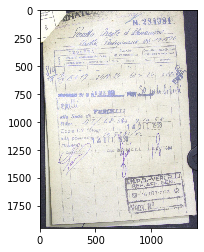


../../download_from_drive/data/ProcessedO7/11916_O7_0450.jpg


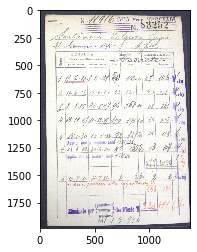


../../download_from_drive/data/ProcessedO7/11916_O7_0452.jpg


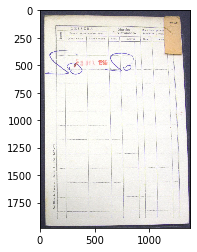


../../download_from_drive/data/ProcessedO7/12503_O7_0588.jpg


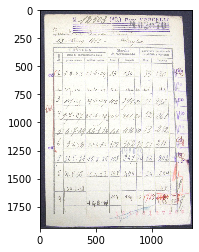


../../download_from_drive/data/ProcessedO7/12503_O7_0590.jpg


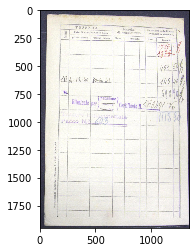


../../download_from_drive/data/ProcessedO7/12503_O7_0592.jpg


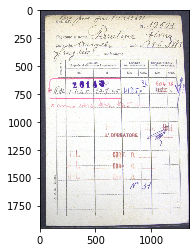


../../download_from_drive/data/ProcessedO7/13745_O7_0440.jpg


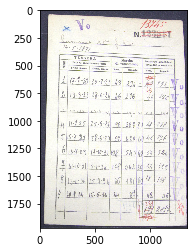


../../download_from_drive/data/ProcessedO7/13745_O7_0442.jpg


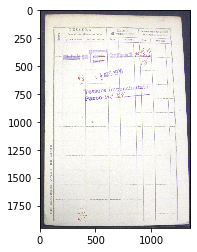


../../download_from_drive/data/ProcessedO7/1424_O7_0604.jpg


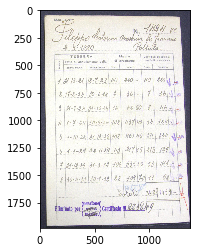


../../download_from_drive/data/ProcessedO7/1424_O7_0606.jpg


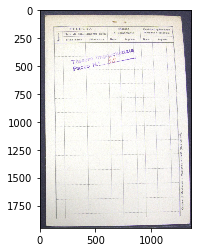


../../download_from_drive/data/ProcessedO7/14975_O7_0866.jpg


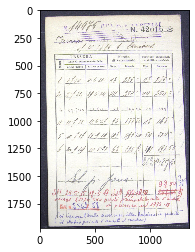


../../download_from_drive/data/ProcessedO7/14975_O7_0868.jpg


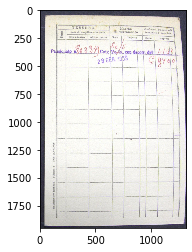


../../download_from_drive/data/ProcessedO7/1617_O7_0090.jpg


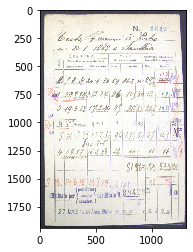


../../download_from_drive/data/ProcessedO7/1617_O7_0092.jpg


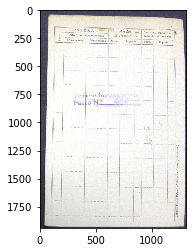


../../download_from_drive/data/ProcessedO7/17221_O7_0680.jpg


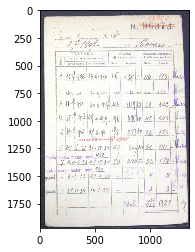

In [15]:
import matplotlib.pyplot as plt

for p in train_ds.data[:25]:
    p = os.path.join("../../download_from_drive/data/ProcessedO7", str(p).split("/")[-1].split('.json')[0])
    print(p)
    plt.imshow(plt.imread(p))
    plt.show()
    print()

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

file =  '../../download_from_drive/data/ProcessedO7/17221_O7_0680.jpg'

im1 = cv2.imread(file)
im = cv2.imread(file)

ret,thresh_value = cv2.threshold(im1,180,255,cv2.THRESH_BINARY_INV)

kernel = np.ones((5,5),np.uint8)
dilated_value = cv2.dilate(thresh_value,kernel,iterations = 1)

# contours, hierarchy = cv2.findContours(dilated_value,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

r = cv2.findContours(dilated_value, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)#TREE,cv2.CHAIN_APPROX_SIMPLE)

# cordinates = []
# for cnt in contours:
#     x,y,w,h = cv2.boundingRect(cnt)
#     cordinates.append((x,y,w,h))
#     #bounding the images
#     if y< 50:
        
#         cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),1)
        
# plt.imshow(im)
# plt.show()


error: OpenCV(4.5.3) /tmp/pip-req-build-9gwtlx3c/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
